<a href="https://colab.research.google.com/github/frawnda/HM-X-Google-Use-Case-1/blob/main/Horizon_Hackathon_Movie_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task
* Create a model to predict the `revenue` of a given movie.  Evaluation will be based on the `mean_absolute_error` of 50 holdout movies, defined in the colab below.

### Imports

In [ ]:
! pip install -q kagglehub[pandas-datasets]
! pip install -q scikit-learn

In [ ]:
pip install -q -U google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
! pip install -q google-cloud-automl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import json
from sklearn.metrics import mean_absolute_percentage_error
from google import genai
from google.genai import types
import sklearn
import joblib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Load Data

In [ ]:
import csv
from kagglehub import KaggleDatasetAdapter, load_dataset

credit_data = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "tmdb/tmdb-movie-metadata",
    "tmdb_5000_credits.csv",
    pandas_kwargs={
        "encoding":    "latin-1",       # or "cp1252"
        "engine":      "python",        # you already had this
        "sep":         ",",             # make sure it's comma‑delimited
        "quoting":     csv.QUOTE_NONE,  # disable pandas quote-pairing
        "on_bad_lines":"skip"           # skip any truly malformed rows
    }
)



In [ ]:
credit_data.head(1)

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,movie_id,title,cast,crew
19995,Avatar,"""[{""""cast_id"""": 242","""""character"""": """"Jake Sully""""","""""credit_id"""": """"5602a8a7c3a3685532001c9a""""","""""gender"""": 2","""""id"""": 65731","""""name"""": """"Sam Worthington""""","""""order"""": 0}","{""""cast_id"""": 3","""""character"""": """"Neytiri""""","""""credit_id"""": """"52fe48009251416c750ac9cb""""","""""gender"""": 1","""""id"""": 8691","""""name"""": """"Zoe Saldana""""","""""order"""": 1}","{""""cast_id"""": 25","""""character"""": """"Dr. Grace Augustine""""","""""credit_id"""": """"52fe48009251416c750aca39""""","""""gender"""": 1","""""id"""": 10205","""""name"""": """"Sigourney Weaver""""","""""order"""": 2}","{""""cast_id"""": 4","""""character"""": """"Col. Quaritch""""","""""credit_id"""": """"52fe48009251416c750ac9cf""""","""""gender"""": 2","""""id"""": 32747","""""name"""": """"Stephen Lang""""","""""order"""": 3}","{""""cast_id"""": 5","""""character"""": """"Trudy Chacon""""","""""credit_id"""": """"52fe48009251416c750ac9d3""""","""""gender"""": 1","""""id"""": 17647","""""name"""": """"Michelle Rodriguez""""","""""order"""": 4}","{""""cast_id"""": 8","""""character"""": """"Selfridge""""","""""credit_id"""": """"52fe48009251416c750ac9e1""""","""""gender"""": 2","""""id"""": 1771","""""name"""": """"Giovanni Ribisi""""","""""order"""": 5}","{""""cast_id"""": 7","""""character"""": """"Norm Spellman""""","""""credit_id"""": """"52fe48009251416c750ac9dd""""","""""gender"""": 2","""""id"""": 59231","""""name"""": """"Joel David Moore""""","""""order"""": 6}","{""""cast_id"""": 9","""""character"""": """"Moat""""","""""credit_id"""": """"52fe48009251416c750ac9e5""""","""""gender"""": 1","""""id"""": 30485","""""name"""": """"CCH Pounder""""","""""order"""": 7}","{""""cast_id"""": 11","""""character"""": """"Eytukan""""","""""credit_id"""": """"52fe48009251416c750ac9ed""""","""""gender"""": 2","""""id"""": 15853","""""name"""": """"Wes Studi""""","""""order"""": 8}","{""""cast_id"""": 10","""""character"""": """"Tsu'Tey""""","""""credit_id"""": """"52fe48009251416c750ac9e9""""","""""gender"""": 2","""""id"""": 10964","""""name"""": """"Laz Alonso""""","""""order"""": 9}","{""""cast_id"""": 12","""""character"""": """"Dr. Max Patel""""","""""credit_id"""": """"52fe48009251416c750ac9f1""""","""""gender"""": 2","""""id"""": 95697","""""name"""": """"Dileep Rao""""","""""order"""": 10}","{""""cast_id"""": 13","""""character"""": """"Lyle Wainfleet""""","""""credit_id"""": """"52fe4800

In [ ]:
from kagglehub import KaggleDatasetAdapter, load_dataset

movie_data = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "tmdb/tmdb-movie-metadata",
    "tmdb_5000_movies.csv",
    pandas_kwargs={
        "encoding":    "latin-1",   # or "cp1252"
        "engine":      "python",    # handles weird line breaks better
        "on_bad_lines":"skip"       # optional: skip malformed rows
    }
)

In [ ]:
movie_data.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [ ]:
movie_data = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "tmdb/tmdb-movie-metadata",
    "tmdb_5000_movies.csv",
)

credit_data = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "tmdb/tmdb-movie-metadata",
    "tmdb_5000_credits.csv",
)

# 2) Rename both 'id' columns to the shared key:
movie_data.rename(columns={"id": "movie_id"}, inplace=True)
credit_data.rename(columns={"id": "movie_id"}, inplace=True)

# 3) Merge on "movie_id"
tmdb_movie_data_all = pd.merge(
    movie_data,
    credit_data,
    on="movie_id",
    how="inner"   # or "left" if you want all movies, even those missing credits
)

tmdb_movie_data_all.head(3)

,budget,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [ ]:
tmdb_movie_data_all.columns

Index(['budget', 'genres', 'homepage', 'movie_id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title_x', 'vote_average', 'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

In [ ]:
len(tmdb_movie_data_all['movie_id'])

4803

### Test Movie Ids
**You must exclude these ids from your training set of data.**

In [ ]:
evaluation_data = (
  tmdb_movie_data_all[tmdb_movie_data_all['production_companies'].str.contains('Lionsgate')]
  .sort_values('revenue', ascending=False)
  .iloc[0:50, [3,12]]
)
evaluation_data.head(5)

,movie_id,revenue
183,101299,847423452
200,131631,752100229
426,70160,691210692
102,131634,653428261
370,291805,334901337


In [ ]:
evaluation_movie_ids = evaluation_data['movie_id'].to_numpy()
evaluation_revenue = evaluation_data['revenue'].to_numpy()

evaluation_movie_ids

array([101299, 131631,  70160, 131634, 291805, 262504,  41439,  11917,
        14435,  37821,  23483, 291870,  50348, 273481, 328387,   1690,
        76494, 100241,   5176,  22804,  22970, 243940,  10030,  19901,
        43539,   7445,  18501,  10431,   8285,   9794,   5393,  13596,
        60599,  15092, 157849, 210860,  14536, 200505,  59440, 127560,
        58431, 302156,    500,  12142,  13408,  13056, 157544,  14271,
       287424, 265208])

### Train Movie Ids

In [ ]:
training_movie_ids = np.array([
  movie_id for movie_id in tmdb_movie_data_all['movie_id'] if movie_id not in evaluation_movie_ids
])

print(len(training_movie_ids))
training_movie_ids


4753


array([ 19995,    285, 206647, ..., 231617, 126186,  25975])

### Example Code to Unpack Json Column

In [ ]:
tmdb_movie_data_all['cast'] = (
  tmdb_movie_data_all['cast']
  .apply(lambda x: json.loads(x))
)



In [ ]:
tmdb_movie_data_all['cast'].head(10)

,cast
0,"[{'cast_id': 242, 'character': 'Jake Sully', '..."
1,"[{'cast_id': 4, 'character': 'Captain Jack Spa..."
2,"[{'cast_id': 1, 'character': 'James Bond', 'cr..."
3,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba..."
4,"[{'cast_id': 5, 'character': 'John Carter', 'c..."
5,"[{'cast_id': 30, 'character': 'Peter Parker / ..."
6,"[{'cast_id': 34, 'character': 'Flynn Rider (vo..."
7,"[{'cast_id': 76, 'character': 'Tony Stark / Ir..."
8,"[{'cast_id': 3, 'character': 'Harry Potter', '..."
9,"[{'cast_id': 18, 'character': 'Bruce Wayne / B..."


In [ ]:
#Lets get below attributes for model building:
# movie_id
# original_title
# genres
# overview
# popularity
# production Company
# release_data
# production_companies
# runtime
# tagline
# vote_avarega
# vote_count
# Cast1
# cast2
# Cast3


In [ ]:
for i,r in tmdb_movie_data_all.iterrows():
  print(r)
  print(i)
  # for cast_i in r['cast']:
  #     cast_feature_data.append([r['movie_id'], cast_i['name']])

Streaming output truncated to the last 5000 lines.
budget                                                                  0
genres                  [{"id": 16, "name": "Animation"}, {"id": 35, "...
homepage                                                              NaN
movie_id                                                            52032
keywords                [{"id": 2526, "name": "human animal relationsh...
original_language                                                      en
original_title                                               My Dog Tulip
overview                The story of a man who rescues a German shephe...
popularity                                                       1.170257
production_companies    [{"name": "Norman Twain Productions", "id": 88...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-01-01
revenue                                                      

In [ ]:
# credit_data['cast'] = (
#   credit_data['cast']
#   .apply(lambda x: json.loads(x))
# )

cast_feature_data = []


for i,r in credit_data.iterrows():
  # Convert the 'cast' column to a list of dictionaries using json.loads
  cast_list = json.loads(r['cast'])
  for cast_i in cast_list:
      cast_feature_data.append([r['movie_id'], cast_i['name']])


cast_feature = pd.DataFrame(
  cast_feature_data,
  columns=['movie_id', 'cast_member']
)

In [ ]:
cast_feature = pd.DataFrame(cast_feature_data)

In [ ]:
cast_feature.head(20)

,0,1
0,19995,Sam Worthington
1,19995,Zoe Saldana
2,19995,Sigourney Weaver
3,19995,Stephen Lang
4,19995,Michelle Rodriguez
5,19995,Giovanni Ribisi
6,19995,Joel David Moore
7,19995,CCH Pounder
8,19995,Wes Studi
9,19995,Laz Alonso


### Example Code to Call Gemini for an Embedding

* Embedding to represent the movie overview.
* Embedding to represent cast, such as an average of the embeddings for the entire cast.
* Could take the cast and overview and genres and get an embedding to represent all teh content as a single string.

In [ ]:
api_key = "xxxxxxxxxx" 
# insert API key during testing

In [ ]:
client = genai.Client(api_key=api_key)

In [ ]:
contents = movie_data['overview'].tolist()[0:5]

result = client.models.embed_content(
  model="gemini-embedding-exp-03-07",
  contents=contents,
  config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY")
)

In [ ]:
embeddings = [x.values for x in result.embeddings]

In [ ]:
embeddings[0][0:3]

[-0.026876846, -0.00811482, 0.0046575973]

In [ ]:
embeddings[1][0:3]

[-0.039739244, -0.010465911, 0.022981776]

In [ ]:
len(embeddings[0])

3072

### Training Data

In [ ]:
train_data = movie_data[[
  "movie_id",
  "budget",
  "vote_average",
  "revenue"
]]

train_data = train_data[
  train_data["movie_id"].isin(training_movie_ids)
]

### Evaluation Data

In [ ]:
evaluation_data = movie_data[
  movie_data["movie_id"].isin(evaluation_movie_ids)
]

evaluation_features = evaluation_data[[
  "budget",
  "vote_average",
]]

# THE MODEL


In [ ]:
# ─────────── Cell 1: INSTALL & IMPORTS ───────────
!pip install -q kagglehub[pandas-datasets] scikit-learn google-genai google-cloud-automl

import pandas as pd
import numpy as np
import json, csv, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from kagglehub import KaggleDatasetAdapter, load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 4.8 MB/s eta 0:00:00


In [ ]:
# ───────── Cell 2: LOAD & MERGE DATA (fixed quoting) ─────────
import csv

# 2a) Load TMDB credits (let pandas handle quotes normally)
credit_data = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "tmdb/tmdb-movie-metadata",
    "tmdb_5000_credits.csv",
    pandas_kwargs={
        "encoding":    "latin-1",
        "engine":      "python",
        "on_bad_lines":"skip"
        # <-- removed quoting=csv.QUOTE_NONE
    }
)
print("▶ raw credit_data shape:", credit_data.shape)

# 2b) Load TMDB movies
movie_data = load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "tmdb/tmdb-movie-metadata",
    "tmdb_5000_movies.csv",
    pandas_kwargs={
        "encoding":    "latin-1",
        "engine":      "python",
        "on_bad_lines":"skip"
    }
)
print("▶ raw movie_data shape: ", movie_data.shape)

# 2c) Normalize & cast the ID columns
# -- movies file uses 'id'
movie_data = movie_data.rename(columns={"id":"movie_id"})
movie_data["movie_id"] = pd.to_numeric(movie_data["movie_id"], errors="coerce")
movie_data = movie_data.dropna(subset=["movie_id"])
movie_data["movie_id"] = movie_data["movie_id"].astype(int)

# -- credits file already has 'movie_id'
credit_data["movie_id"] = pd.to_numeric(credit_data["movie_id"], errors="coerce")
credit_data = credit_data.dropna(subset=["movie_id"])
credit_data["movie_id"] = credit_data["movie_id"].astype(int)
print("▶ cleaned credit_data shape:", credit_data.shape)

# 2d) Merge on movie_id
tmdb = pd.merge(movie_data, credit_data, on="movie_id", how="inner")
print("▶ tmdb shape after merge:", tmdb.shape)


▶ raw credit_data shape: (4803, 4)
▶ raw movie_data shape:  (4803, 20)
▶ cleaned credit_data shape: (4803, 4)
▶ tmdb shape after merge: (4803, 23)


In [ ]:
# ───────── Cell 3: SPLIT TRAIN vs HOLD‑OUT ─────────
# Hold‑out = the top 50 “Lionsgate” films by revenue
lion_mask = tmdb["production_companies"].str.contains("Lionsgate", na=False)
eval_ids  = (
    tmdb.loc[lion_mask]
        .nlargest(50, "revenue")["movie_id"]
        .to_numpy()
)

# Everything else → training
train_ids = tmdb.loc[~tmdb["movie_id"].isin(eval_ids), "movie_id"].to_numpy()

# Slice
train_df = tmdb[tmdb["movie_id"].isin(train_ids)].copy()
eval_df  = tmdb[tmdb["movie_id"].isin(eval_ids)].copy()

# Sanity check
print("▶ train_df shape:", train_df.shape)
print("▶ eval_df  shape:",  eval_df.shape)


▶ train_df shape: (4753, 23)
▶ eval_df  shape: (50, 23)


In [ ]:
# ───────── Cell 3.5: CLIP OUT EXTREME REVENUES (OPTIONAL) ─────────
import numpy as np

# 1) Compute the cutoff (e.g. 95th percentile of train revenues)
cutoff = np.percentile(train_df["revenue"], 95)
print(f"Clipping any film with revenue > ${cutoff:,.0f}")

# 2) Filter both train & eval to the same range
train_df = train_df[train_df["revenue"] <= cutoff].copy()
eval_df  = eval_df[ eval_df["revenue"]  <= cutoff].copy()

# 3) Report new sizes
print(f"▶ train_df now: {train_df.shape[0]} rows")
print(f"▶ eval_df  now: {eval_df.shape[0]} rows")


Clipping any film with revenue > $368,872,908
▶ train_df now: 4515 rows
▶ eval_df  now: 46 rows


In [ ]:
# ───────── Cell 4: FEATURE ENGINEERING & FEATURE LISTS ─────────
import json
import pandas as pd

# A) Compute cast_size
for df in (train_df, eval_df):
    # parse the JSON‐string into a Python list (if needed)
    df["cast_list"] = df["cast"].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )
    df["cast_size"] = df["cast_list"].apply(len)

# B) Compute production company count
for df in (train_df, eval_df):
    df["prod_comp_count"] = df["production_companies"].apply(
        lambda x: len(json.loads(x)) if isinstance(x, str) else 0
    )

# C) Extract main_genre from the genres JSON
for df in (train_df, eval_df):
    df["genres_list"] = df["genres"].apply(
        lambda x: [g["name"] for g in json.loads(x)] if isinstance(x, str) else []
    )
    df["main_genre"] = df["genres_list"].apply(lambda L: L[0] if L else "Unknown")

# D) Ensure vote_count is numeric
for df in (train_df, eval_df):
    df["vote_count"] = df["vote_count"].astype(float)

# E) Extract release_month
for df in (train_df, eval_df):
    df["release_month"] = (
        pd.to_datetime(df["release_date"], errors="coerce")
          .dt.month
          .fillna(0)
          .astype(int)
    )

# F) Define our feature lists for the pipeline
NUM_COLS = [
    "budget",
    "popularity",
    "runtime",
    "vote_average",
    "vote_count",
    "cast_size",
    "prod_comp_count",
]
TEXT_COL = "overview"
CAT_COL  = ["main_genre", "release_month"]

print("✅ Done feature‐engineering!")
print("NUM_COLS =", NUM_COLS)
print("CAT_COL  =", CAT_COL)


✅ Done feature‐engineering!
NUM_COLS = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'cast_size', 'prod_comp_count']
CAT_COL  = ['main_genre', 'release_month']


In [ ]:
# ───────── Cell 5: DEFINE PREPROCESSOR & RANDOM FOREST PIPELINE ─────────
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble        import RandomForestRegressor

# 5a) Numeric sub‐pipeline: impute missing → standardize
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",   StandardScaler())
])

# 5b) Text sub‐pipeline: impute missing → squeeze to 1D → TF‑IDF
text_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="")),
    ("squeeze", FunctionTransformer(lambda X: X[:, 0], validate=False)),
    ("tfidf",   TfidfVectorizer(max_features=500, stop_words="english"))
])

# 5c) Combine into a ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_pipe,        NUM_COLS),        # all your numeric cols
    ("txt", text_pipe,       [TEXT_COL]),      # overview text
    ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COL),  # genre & month
], remainder="drop")

# 5d) Final RF pipeline: preprocessing → RandomForestRegressor
rf_pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestRegressor(
                n_estimators=100,
                max_depth=20,
                random_state=0,
                n_jobs=-1
           ))
], verbose=True)

print("✅ Preprocessor + RandomForest pipeline defined.")


✅ Preprocessor + RandomForest pipeline defined.


In [ ]:
# ───────── Cell 6: WRAP IN LOG1P TARGET & FIT ─────────
from sklearn.compose import TransformedTargetRegressor
import numpy as np

# Wrap so we train on log1p(revenue) and invert back to dollars
log_pipe = TransformedTargetRegressor(
    regressor    = rf_pipeline,
    func         = np.log1p,
    inverse_func = np.expm1
)

# Fit on your full (non‐clipped) train set
log_pipe.fit(
    train_df[NUM_COLS + [TEXT_COL] + CAT_COL],
    train_df["revenue"]
)

print(f"✅ log_pipe fitted on {len(train_df)} samples.")


[Pipeline] ............... (step 1 of 2) Processing pre, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  37.8s
✅ log_pipe fitted on 4515 samples.


📊 Hold‑out MAPE (actual>0): 139.48%


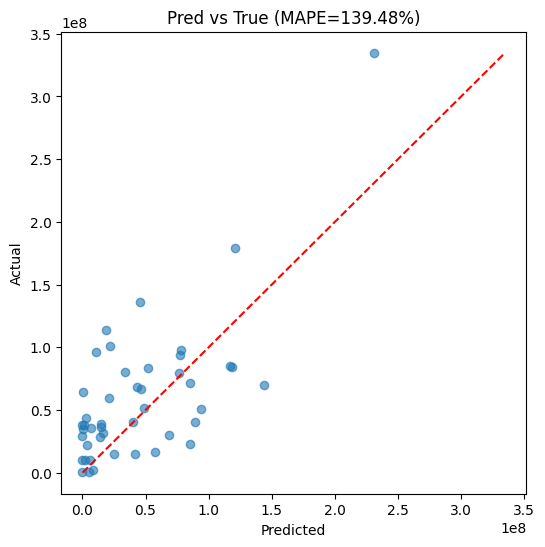

In [ ]:
# ───────── Cell 7: EVALUATE & INTERACT ─────────
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 7a) Evaluate on hold‑out, masking zeros
X_hold = eval_df[NUM_COLS + [TEXT_COL] + CAT_COL]
y_hold = eval_df["revenue"]
y_pred = log_pipe.predict(X_hold)

mask = y_hold > 0
mape = mean_absolute_percentage_error(y_hold[mask], y_pred[mask])
print(f"📊 Hold‑out MAPE (actual>0): {mape:.2%}")

plt.figure(figsize=(6,6))
plt.scatter(y_pred[mask], y_hold[mask], alpha=0.6)
plt.plot([0, y_hold[mask].max()],[0, y_hold[mask].max()],'r--')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Pred vs True (MAPE={mape:.2%})")
plt.show()




In [ ]:
# ───────── Cell 7b: SINGLE‑MOVIE PROMPT (with detailed guidance) ─────────
def prompt_float(prompt):
    while True:
        try:
            return float(input(prompt))
        except ValueError:
            print("  ❌ Please enter a valid number.")

print("\n🎬 Predict a new movie")
print("  (We’ll ask you for the key inputs—just follow the examples in brackets.)\n")

vals = {}
# 1. Production budget
vals["budget"] = prompt_float(
    "➤ Budget [USD] (e.g. 20000000 for a $20 M production budget): "
)

# 2. Popularity
vals["popularity"] = prompt_float(
    "➤ Popularity score (TMDB’s 0–100 scale; e.g. 35.7): "
)

# 3. Runtime
vals["runtime"] = prompt_float(
    "➤ Runtime [minutes] (e.g. 90–180): "
)

# 4. Average user rating
vals["vote_average"] = prompt_float(
    "➤ Vote average [0.0–10.0] (e.g. 7.3): "
)

# 5. Number of votes
vals["vote_count"] = prompt_float(
    "➤ Vote count (how many users rated this; e.g. 5000): "
)

# 6. Cast size
vals["cast_size"] = prompt_float(
    "➤ Cast size (number of billed cast members; e.g. 10): "
)

# 7. Number of production companies
vals["prod_comp_count"] = prompt_float(
    "➤ Production companies count (e.g. 1–5 studios involved): "
)

# 8. Release month
vals["release_month"] = int(prompt_float(
    "➤ Release month [1–12] (e.g. 7 for July): "
))

# 9. Overview text
print("\n➤ Overview (one- or two-sentence plot summary helps tune text features)")
ov = input("  (or leave blank): ").strip()

# 10. Main genre
print("\n➤ Main genre (pick one category that best fits the film)")
mg = input("  (e.g. Action, Comedy, Drama, Sci-Fi): ").strip().title()

# assemble into a DataFrame and predict
import pandas as pd
row = {**vals, "overview": ov, "main_genre": mg}
df_new = pd.DataFrame([row])

pred = log_pipe.predict(df_new)[0]
print(f"\n✅ Predicted revenue: ${pred:,.0f}")



🎬 Predict a new movie
  (We’ll ask you for the key inputs—just follow the examples in brackets.)

➤ Budget [USD] (e.g. 20000000 for a $20 M production budget): 200000
➤ Popularity score (TMDB’s 0–100 scale; e.g. 35.7): 100
➤ Runtime [minutes] (e.g. 90–180): 180
➤ Vote average [0.0–10.0] (e.g. 7.3): 10
➤ Vote count (how many users rated this; e.g. 5000): 2000
➤ Cast size (number of billed cast members; e.g. 10): 10
➤ Production companies count (e.g. 1–5 studios involved): 5
➤ Release month [1–12] (e.g. 7 for July): 5

➤ Overview (one- or two-sentence plot summary helps tune text features)
  (or leave blank): Minecraft Movie

➤ Main genre (pick one category that best fits the film)
  (e.g. Action, Comedy, Drama, Sci-Fi): Comedy

✅ Predicted revenue: $741,989
